In [59]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "FruitDataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 18452 files belonging to 12 classes.


In [6]:
class_names = dataset.class_names
n_classes = len(class_names)
print("Class Names:", class_names)

Class Names: ['Apple_Bad', 'Apple_Good', 'Banana_Bad', 'Banana_Good', 'Guava_Bad', 'Guava_Good', 'Lime_Bad', 'Lime_Good', 'Orange_Bad', 'Orange_Good', 'Pomegranate_Bad', 'Pomegranate_Good']


In [7]:
def preprocess_image(image, label):
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    return image, label

In [8]:
dataset = dataset.map(preprocess_image)

In [9]:
len(dataset)

577

In [10]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[ 5  7  0 11 10  1  7  7 11  7  5 11 11  5 11 11 11  9  4 10  3  5 11 11
  3  7 11  4  9 11  4  6]


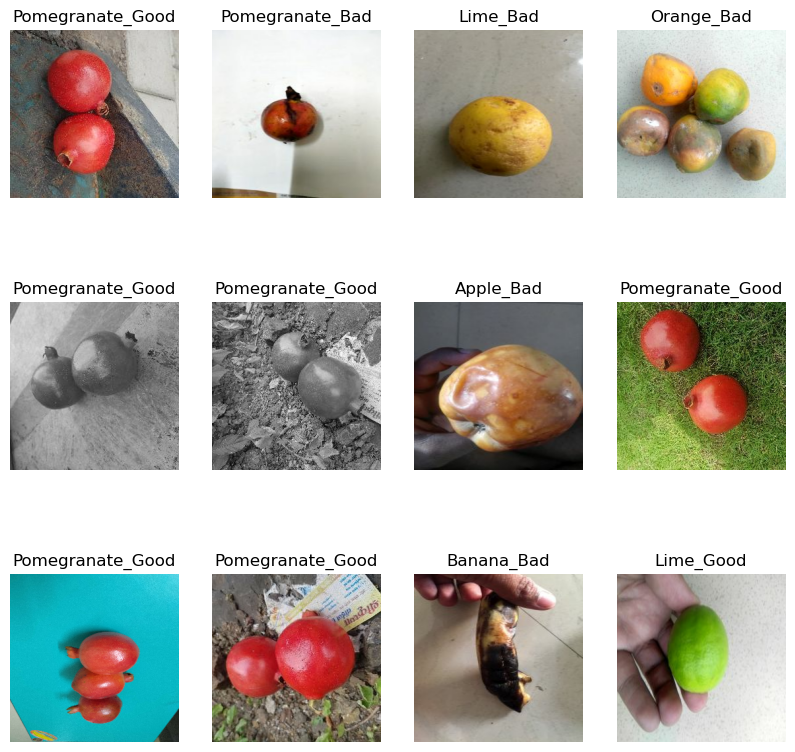

In [11]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## training = 80%
## testing: validation = 10%, testing = 10%

In [10]:
train_size=0.8
len(dataset)*train_size

461.6

In [11]:
train_ds=dataset.take(461)
len(train_ds)

461

In [12]:
577-461

116

In [13]:
test_ds=dataset.skip(461)
len(test_ds)

116

In [14]:
val_size=0.1
len(dataset)*(0.1)

57.7

In [15]:
val_ds=test_ds.take(58)

In [16]:
test_ds=test_ds.skip(58)
len(test_ds)

58

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=7)

    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds
    

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
len(train_ds)

461

In [15]:
len(val_ds)

57

In [16]:
len(test_ds)

59

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
n_classes

12

In [21]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax")    
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # can try changing this to minimize loss
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
461/461 [==============================] - 361s 655ms/step - loss: 1.5727 - accuracy: 0.4507 - val_loss: 0.9561 - val_accuracy: 0.6382
Epoch 2/50
461/461 [==============================] - 254s 551ms/step - loss: 0.7848 - accuracy: 0.7249 - val_loss: 0.6903 - val_accuracy: 0.7593
Epoch 3/50
461/461 [==============================] - 253s 550ms/step - loss: 0.5448 - accuracy: 0.8070 - val_loss: 0.4799 - val_accuracy: 0.8262
Epoch 4/50
461/461 [==============================] - 271s 589ms/step - loss: 0.4269 - accuracy: 0.8512 - val_loss: 0.4014 - val_accuracy: 0.8624
Epoch 5/50
461/461 [==============================] - 247s 535ms/step - loss: 0.3783 - accuracy: 0.8661 - val_loss: 0.3481 - val_accuracy: 0.8690
Epoch 6/50
461/461 [==============================] - 246s 534ms/step - loss: 0.3209 - accuracy: 0.8889 - val_loss: 0.2516 - val_accuracy: 0.9106
Epoch 7/50
461/461 [==============================] - 299s 648ms/step - loss: 0.3045 - accuracy: 0.8950 - val_loss: 0.3728 -

In [25]:
scores = model.evaluate(test_ds)

59/59 [==============================] - 70s 157ms/step - loss: 0.0612 - accuracy: 0.9831


In [26]:
scores

[0.061201129108667374, 0.9830508232116699]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 461}

In [29]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

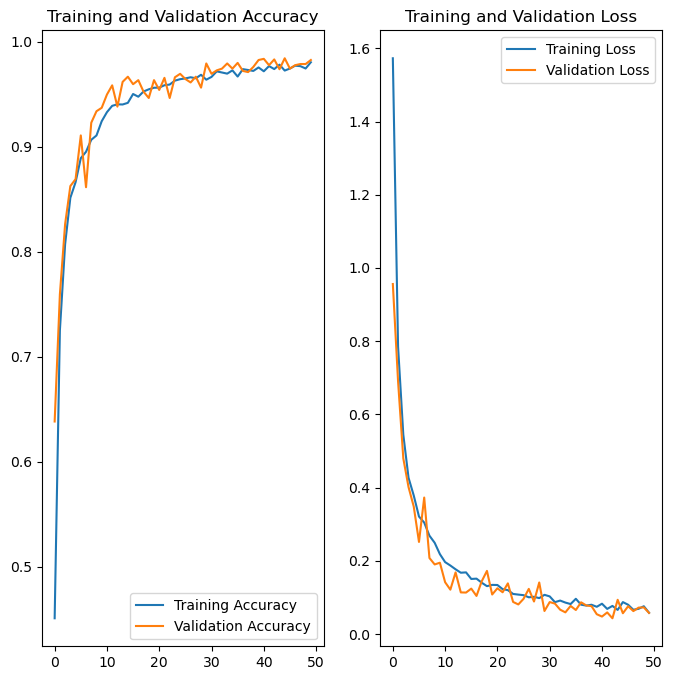

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = "Training Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")

plt.show()

First Image to Predict
First Image's Actual Label: Pomegranate_Good
1/1 [==============================] - 0s 171ms/step
First Image's Predicted Label: Pomegranate_Good


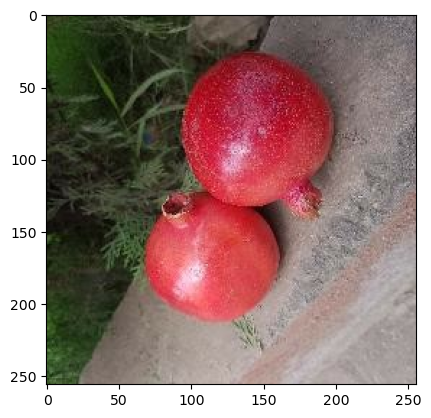

In [47]:
for images_batch, labels_batch in dataset.take(1):

    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("First Image to Predict")
    plt.imshow(first_image)
    print("First Image's Actual Label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("First Image's Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [55]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Creating a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


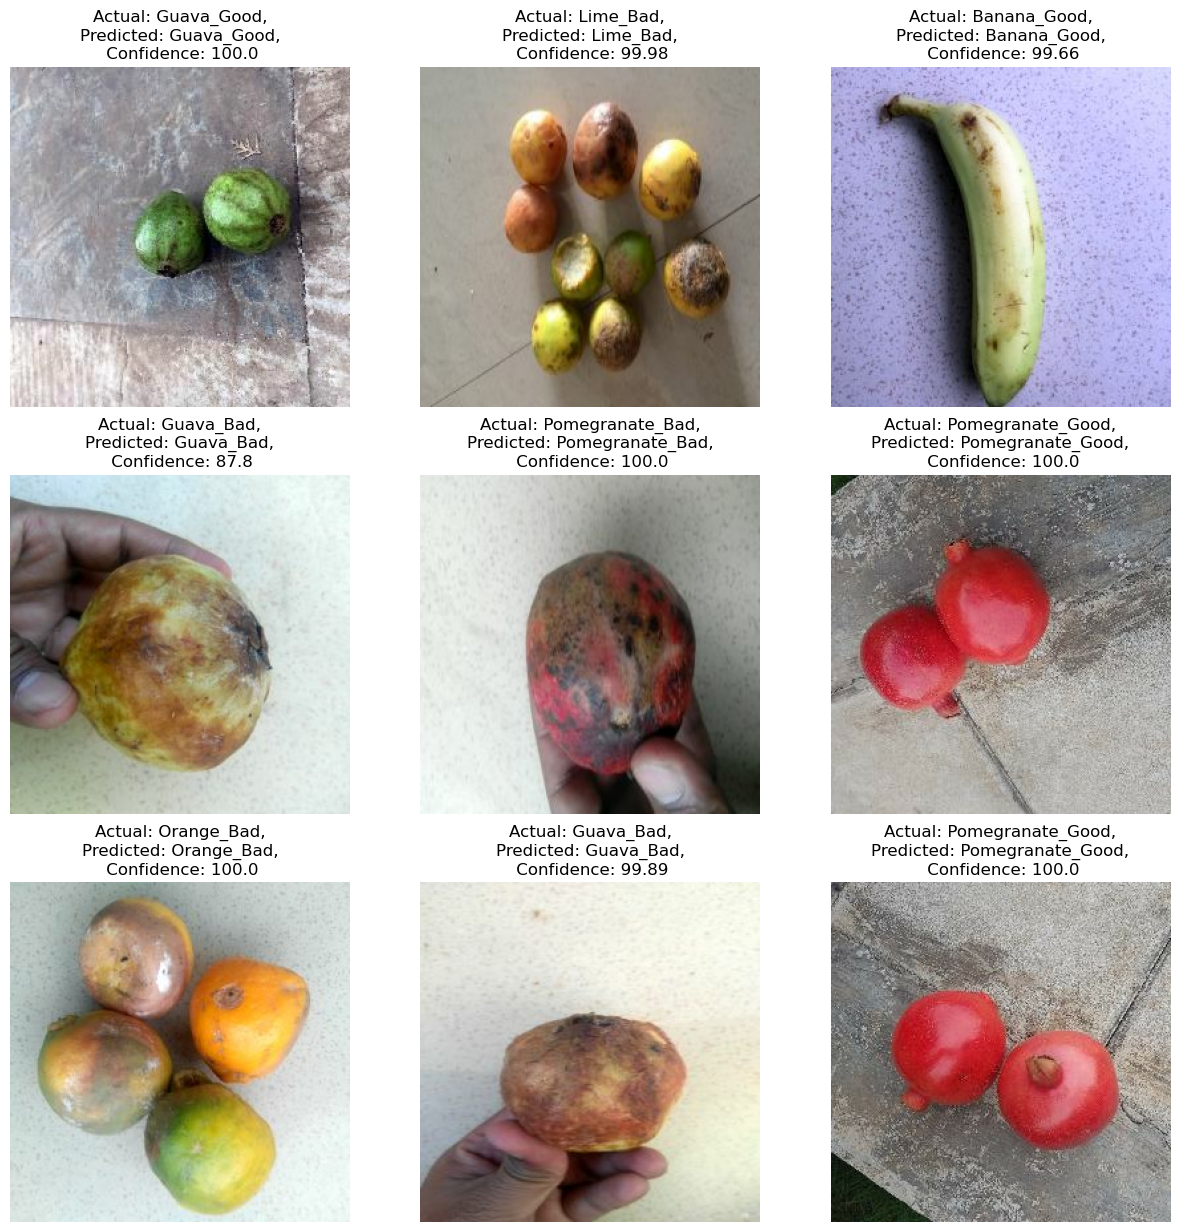

In [57]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\n Confidence: {confidence}")
        
        plt.axis("off")

# Only to create a new version of the model run the code below:

In [ ]:
model_version=max([int(i) for i in os.listdir("../saved_models") + [0]])+1
model.save(f"../saved_models/{model_version}")